In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [238]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [45]:
DATASET_ID = 'marmoset'

In [46]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [235]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [189]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=5000,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 5000,
    butter_highcut = 10000,
    ref_level_db = 25,
    min_level_db = -70,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [190]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

#### Create dataset based upon JSON

In [191]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [192]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["labels", "call_num", "pulse_num"],
            unit="calls",
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

14292

In [193]:
syllable_df[:3]

start_time   end_time labels  call_num  pulse_num indv  indvi  \
0    5.000000   6.688911   phee         5          0  leo      0   
1    7.008134   7.757936   phee         5          1  leo      0   
2   28.414626  29.981045   phee         6          0  leo      0   

                                       key  
0  luna_leo_060317__h0m4s41.47470453938871  
1  luna_leo_060317__h0m4s41.47470453938871  
2  luna_leo_060317__h0m4s41.47470453938871

### get audio for dataset

In [194]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

14292

In [195]:
syllable_df[:3]

start_time   end_time labels  call_num  pulse_num indv  indvi  \
0    5.000000   6.688911   phee         5          0  leo      0   
1    7.008134   7.757936   phee         5          1  leo      0   
2   28.414626  29.981045   phee         6          0  leo      0   

                                       key  \
0  luna_leo_060317__h0m4s41.47470453938871   
1  luna_leo_060317__h0m4s41.47470453938871   
2  luna_leo_060317__h0m4s41.47470453938871   

                                               audio   rate  
0  [-0.0028140772962798664, -0.002767839704774081...  44150  
1  [-0.0017946614847837742, -0.004523495411240861...  44150  
2  [0.001508825282652068, 0.001441084705503678, 0...  44150

In [198]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [199]:
sylls = syllable_df.audio.values

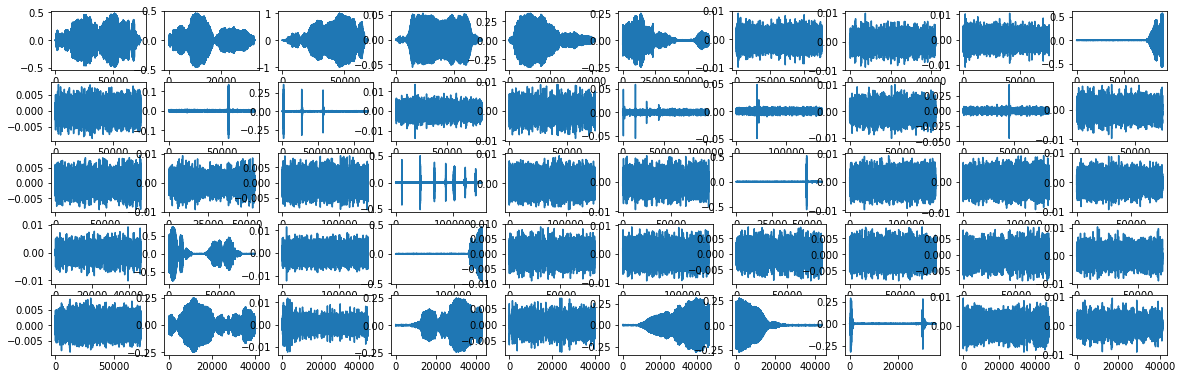

In [200]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [174]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [156]:
syll_mask = syllable_df.labels.values == 'phee'

In [157]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [158]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 194 ta

### Mask/threshold spectrograms to remove noise

In [160]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # Mask spectrograms
    if dataset.hparams.mask_spec:
        syllables_spec = parallel(
            delayed(mask_spec)(syllable, **dataset.hparams.mask_spec_kwargs)
            for syllable in tqdm(
                syllables_spec,
                total=len(syllables_rate),
                desc="masking spectrograms",
                leave=False,
            )
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0117s.) Setting batch_size=34.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1714 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2938 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4298 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 5012 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Don

### Rescale spectrogram
- using log rescaling

In [162]:
log_scaling_factor = 10

In [163]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0172s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1183s.) Setting batch_size=74.
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3636 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 5042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 6448 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8002 tasks      | elapsed:    3.5s
[Para

In [171]:
masked_specs = [np.array(i) for i, j in zip(syllables_spec, syll_mask) if j]
draw_spec_set(masked_specs[12000:], zoom=1, maxrows=10, colsize=25)

(25.0, 10) (320, 800) 25.0 32 800


### Pad spectrograms

In [172]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [176]:
plt.hist(syll_lens)

(array([  16.,   49.,   44.,   65.,  165.,  721., 8175., 4681.,  341.,
          35.]),
 array([36. , 40.9, 45.8, 50.7, 55.6, 60.5, 65.4, 70.3, 75.2, 80.1, 85. ]),
 <a list of 10 Patch objects>)

In [175]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1916s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0304s.) Setting batch_size=26.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0806s.) Setting batch_size=128.
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 5026 tasks      | elap

(25.0, 10) (320, 800) 25.0 32 800


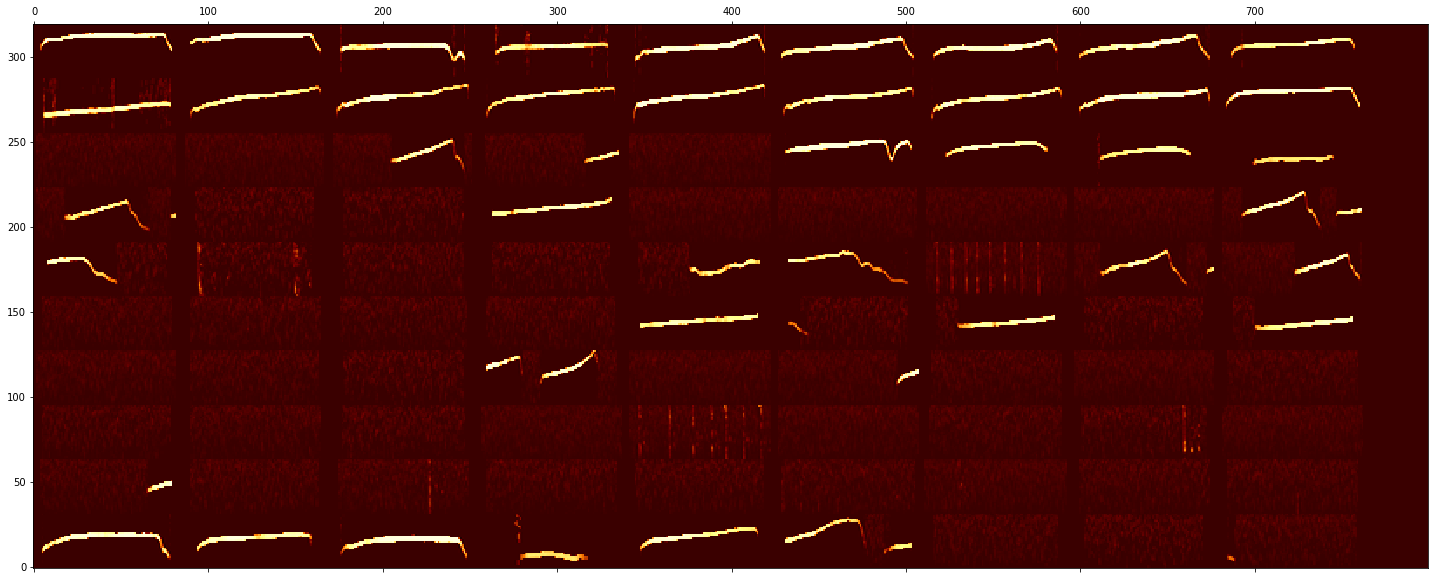

In [182]:
masked_specs = [np.array(i) for i, j in zip(syllables_spec, syll_mask) if j]
draw_spec_set(masked_specs, zoom=1, maxrows=10, colsize=25)

### view indv spectrogram

In [201]:
syllable_df['spectrogram'] = syllables_spec

In [205]:
syllable_df.labels.unique()

array(['phee', 'tsk', 'twitter', 'unknown'], dtype=object)

In [202]:
syllable_df[:3]

start_time   end_time labels  call_num  pulse_num indv  indvi  \
0    5.000000   6.688911   phee         5          0  leo      0   
1    7.008134   7.757936   phee         5          1  leo      0   
2   28.414626  29.981045   phee         6          0  leo      0   

                                       key  \
0  luna_leo_060317__h0m4s41.47470453938871   
1  luna_leo_060317__h0m4s41.47470453938871   
2  luna_leo_060317__h0m4s41.47470453938871   

                                               audio   rate  \
0  [-0.0028140772962798664, -0.002767839704774081...  44150   
1  [-0.0017946614847837742, -0.004523495411240861...  44150   
2  [0.001508825282652068, 0.001441084705503678, 0...  44150   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

Text(0.5, 1.0, 'min')

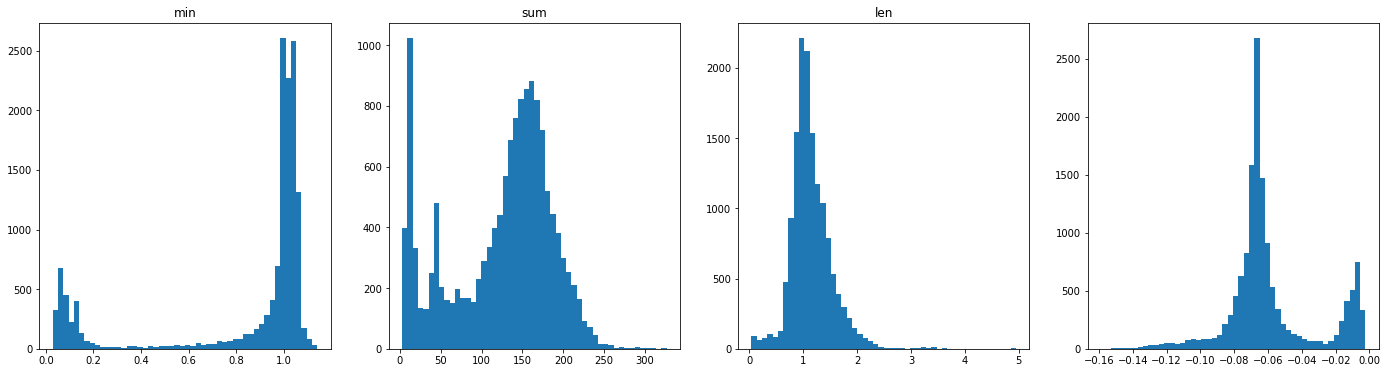

In [234]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')


leo 391
(25.0, 5) (160, 800) 25.0 32 800


todd 1231
(25.0, 5) (160, 800) 25.0 32 800


ares 875
(25.0, 5) (160, 800) 25.0 32 800


aladdin 219
(25.0, 5) (160, 800) 25.0 32 800


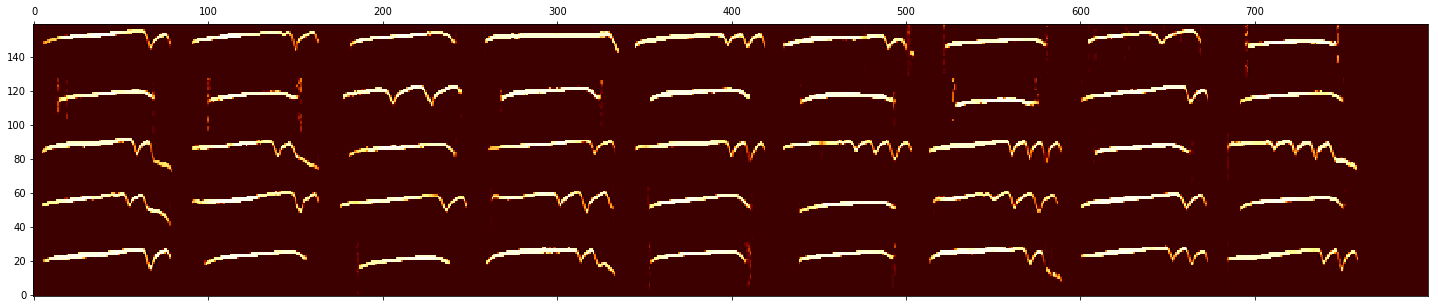

ben 290
(25.0, 5) (160, 800) 25.0 32 800


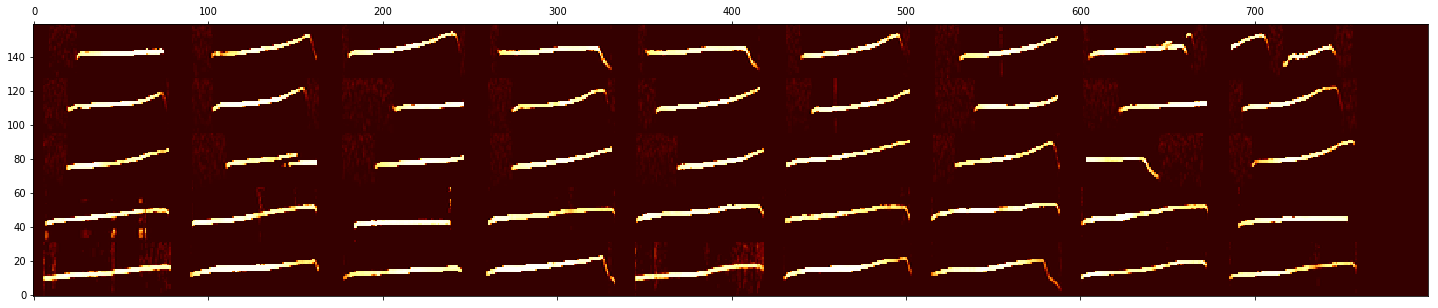

apollo 206
(25.0, 5) (160, 800) 25.0 32 800


baloo 98
(25.0, 5) (160, 800) 25.0 32 800


han 558
(25.0, 5) (160, 800) 25.0 32 800


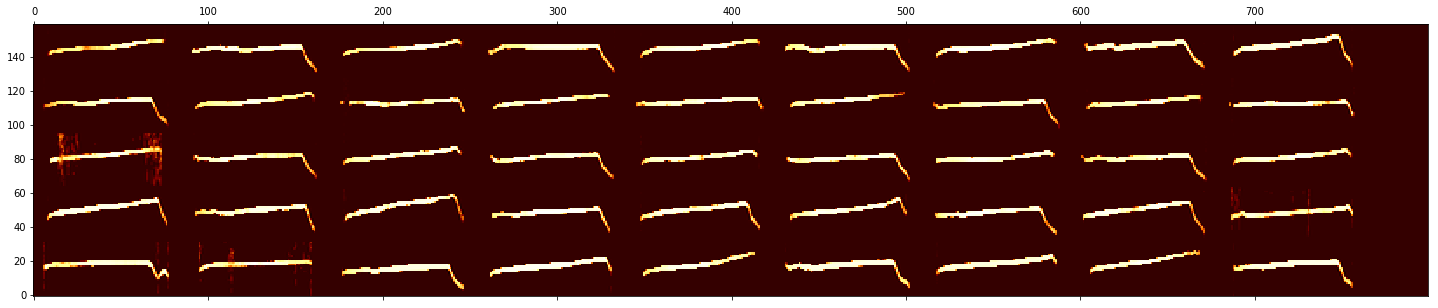

jasmine 237
(25.0, 5) (160, 800) 25.0 32 800


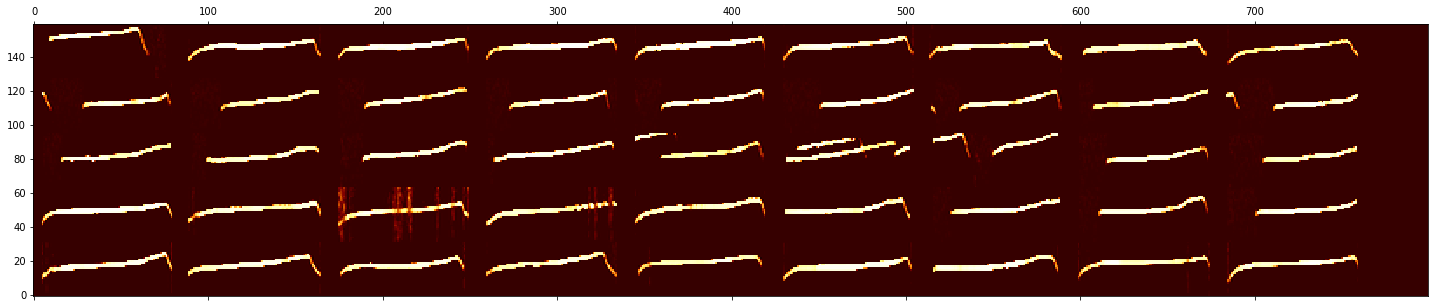

angel 270
(25.0, 5) (160, 800) 25.0 32 800


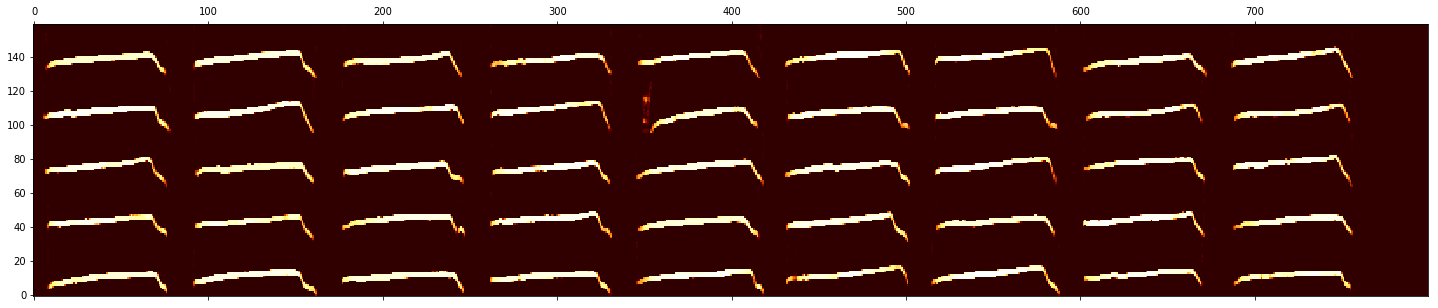

hank 1671
(25.0, 5) (160, 800) 25.0 32 800


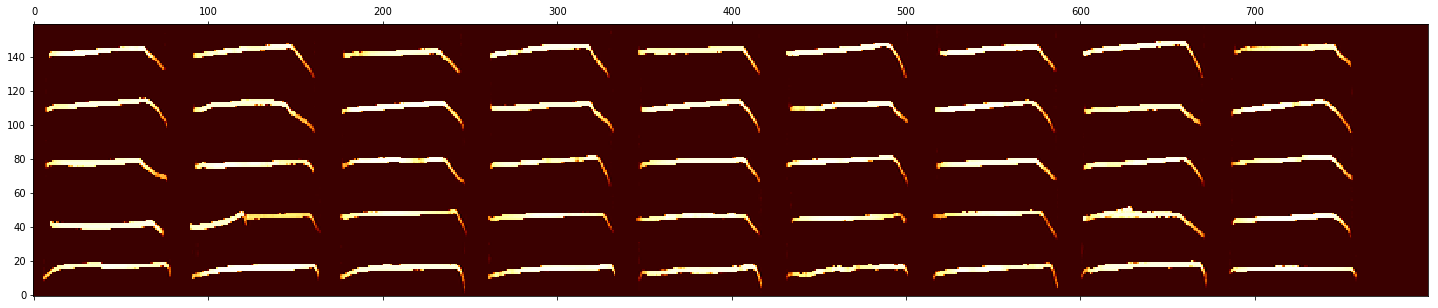

hermes 1671
(25.0, 5) (160, 800) 25.0 32 800


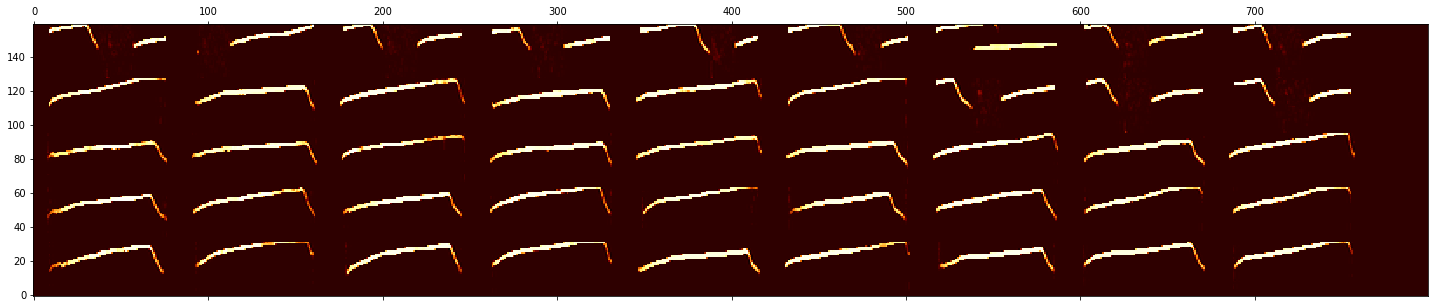

dip 66
(25.0, 5) (160, 800) 25.0 32 800


louie 20
(25.0, 2) (64, 800) 25.0 32 800


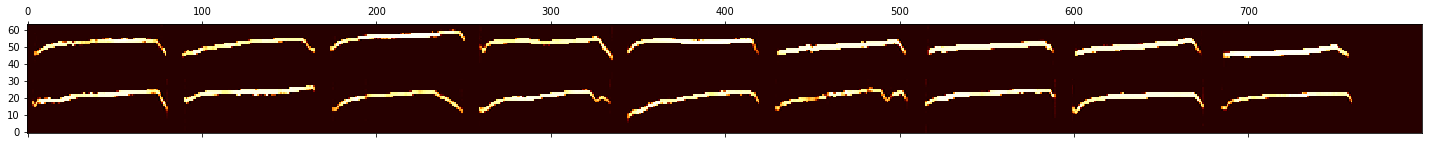

banana 367
(25.0, 5) (160, 800) 25.0 32 800


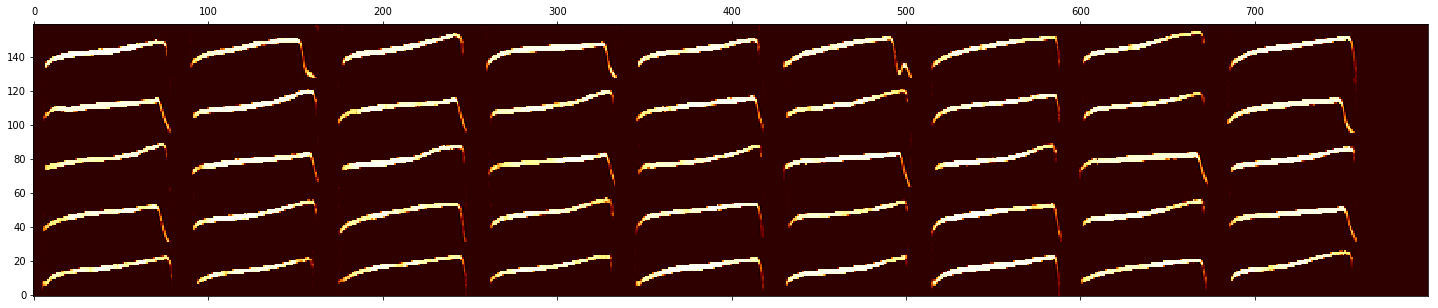

iago 286
(25.0, 5) (160, 800) 25.0 32 800


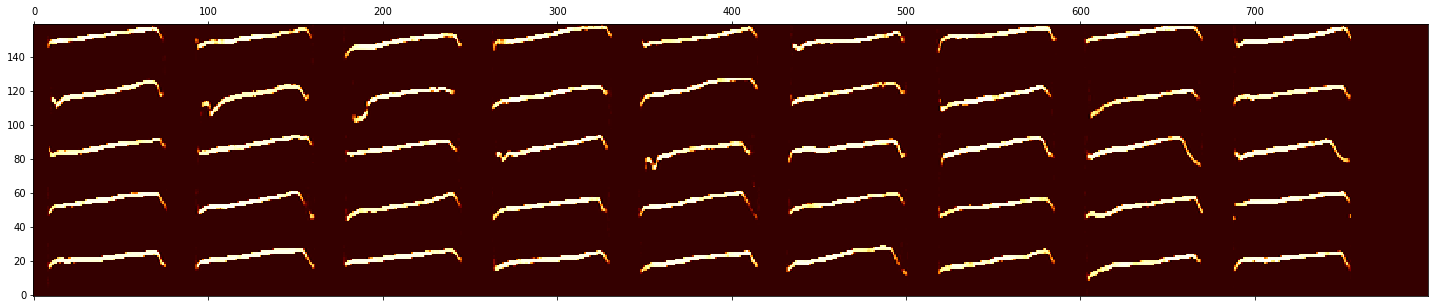

papaya 387
(25.0, 5) (160, 800) 25.0 32 800


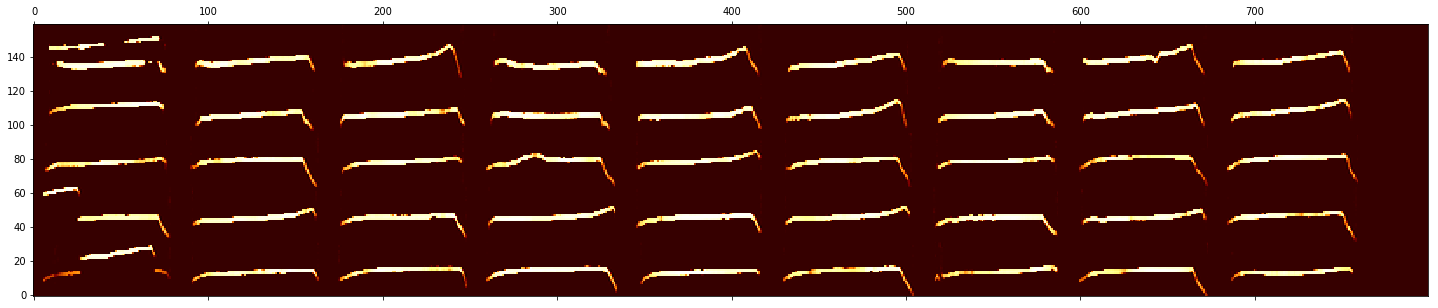

abu 84
(25.0, 5) (160, 800) 25.0 32 800


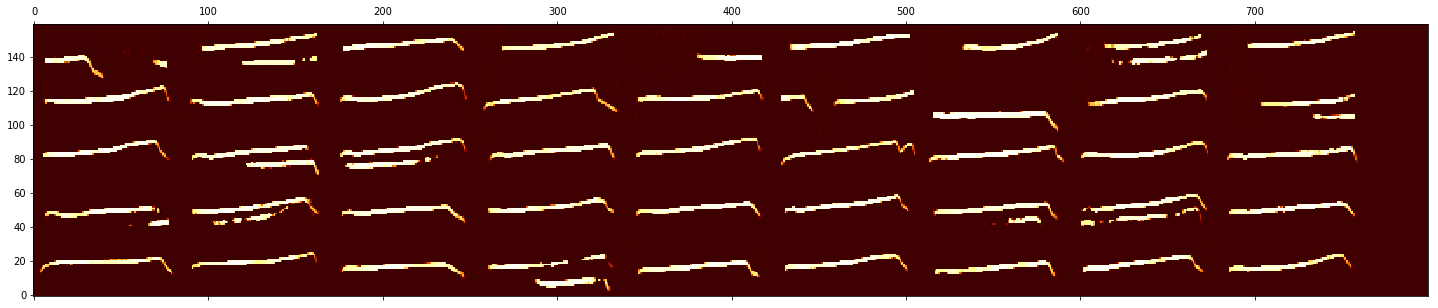

raja 106
(25.0, 5) (160, 800) 25.0 32 800


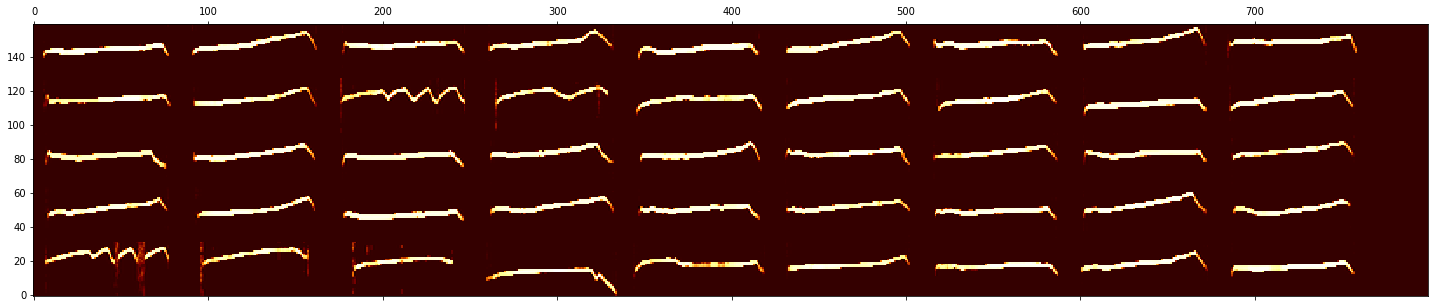

mowgli 12
(25.0, 2) (64, 800) 25.0 32 800


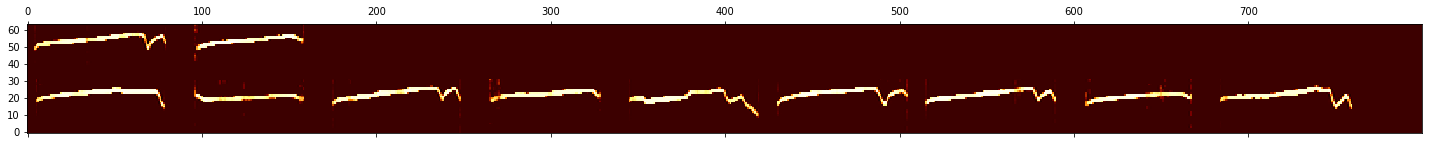

poseidon 373
(25.0, 5) (160, 800) 25.0 32 800


london 584
(25.0, 5) (160, 800) 25.0 32 800


uno 514
(25.0, 5) (160, 800) 25.0 32 800


kit 351
(25.0, 5) (160, 800) 25.0 32 800


nasira 2
(25.0, 1) (32, 800) 25.0 32 800


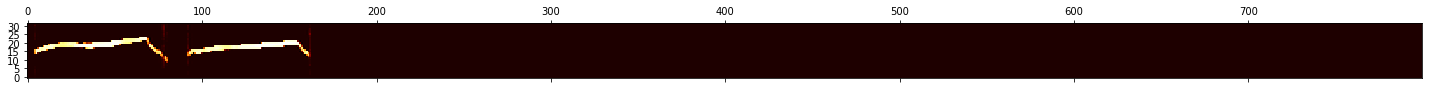

copper 1808
(25.0, 5) (160, 800) 25.0 32 800


waylon 1209
(25.0, 5) (160, 800) 25.0 32 800


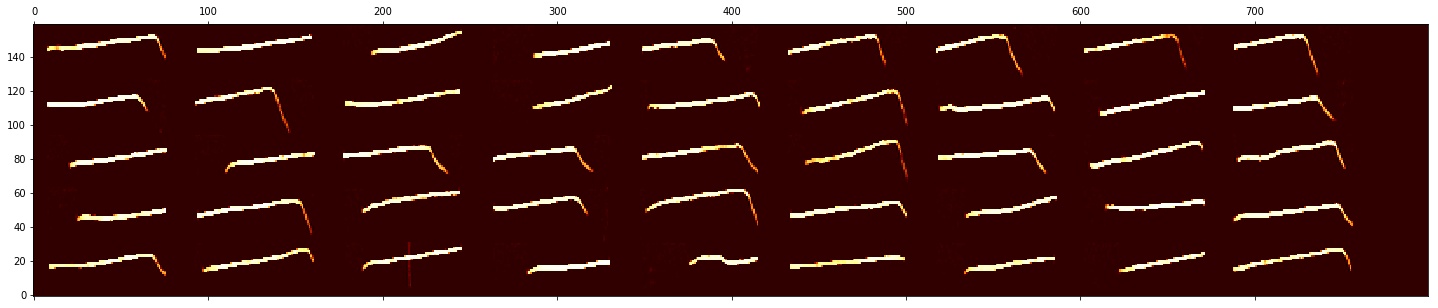

mango 28
(25.0, 3) (96, 800) 25.0 32 800


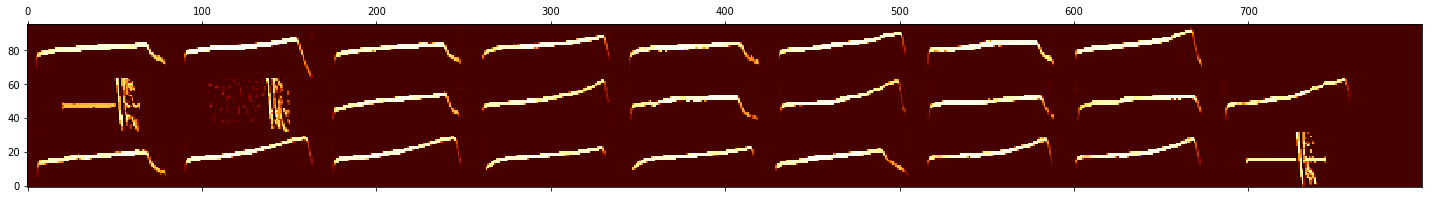

chewie 81
(25.0, 5) (160, 800) 25.0 32 800


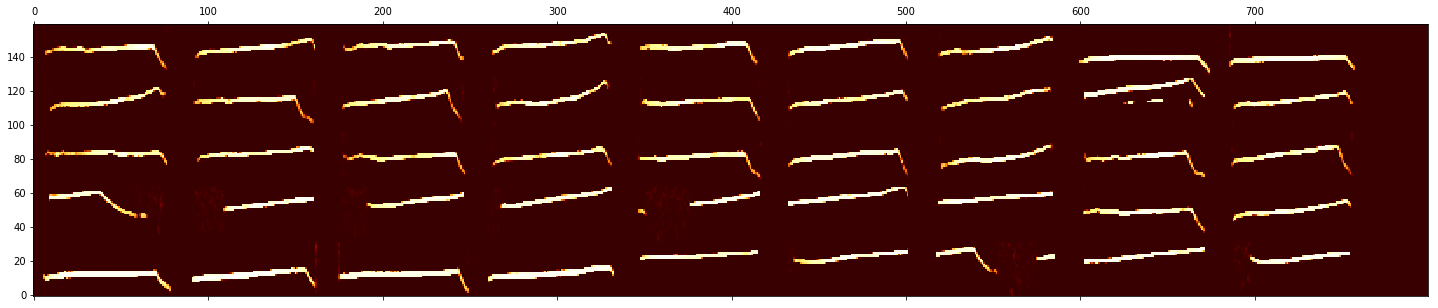

kiwi 5
(25.0, 1) (32, 800) 25.0 32 800


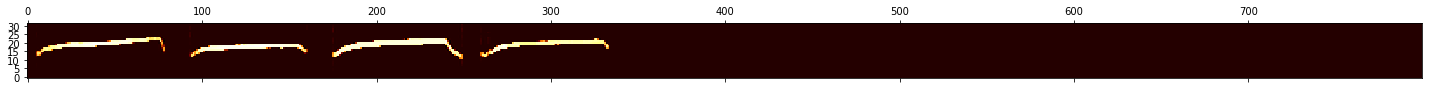

william 282
(25.0, 3) (96, 800) 25.0 32 800


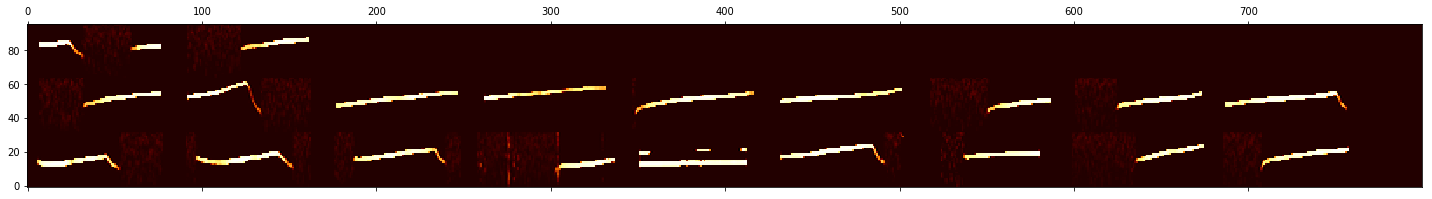

rafiki 7
(25.0, 1) (32, 800) 25.0 32 800


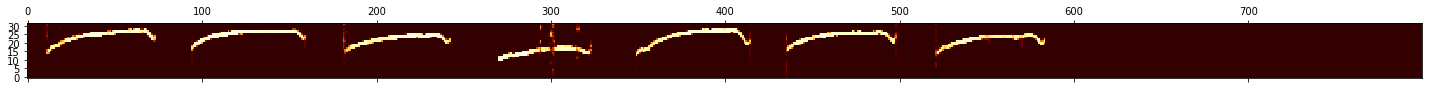

luna 3
(25.0, 1) (32, 800) 25.0 32 800


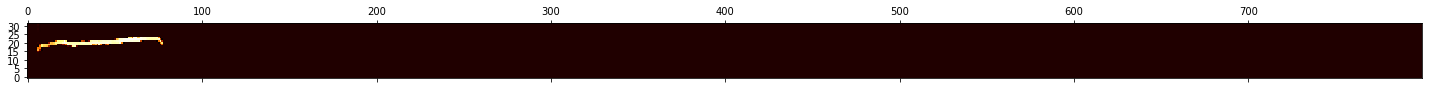

In [231]:
for indv in tqdm(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv== indv))
    specs = syllable_df[syllable_df.indv== indv].spectrogram.values
    specs = [i/np.max(i) for i in specs if np.sum(i) > 100]
    draw_spec_set(specs, zoom=1, maxrows=5, colsize=25)
    plt.show()
    #break

### save syllable dataframe

In [240]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'marmoset.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)